# Analyzing AZ traffic stops

This tutorial is built in Python, a powerful programming language with a wide variety of applications. In addition to Python we will need to bring in some additional tools to make our jobs easier. These tools are:

- [Pandas](https://pandas.pydata.org/) - an open-source toolkit widely used for data analysis. 
- [Altair](https://altair-viz.github.io) - a charting library used in conjunction with Pandas to display data visually.

We need to import these tools before we can start working with them. We also want to assign them shorter names so it's easier to refer to the tools later on.

While we are at it, we are going to set an option so Pandas will display all the columns when we ask it to. We also have to enable Altair so it works with the notebook.

In [1]:
import pandas as pd
import altair as alt

pd.set_option('display.max_columns', 29)
alt.renderers.enable('notebook')

## Loading the data

Now that our tools are in place we can load the data. To do so we will use a function built into Pandas. It's easiest to think of functions as tools that conduct a task. These tools can take different arguments - parameters that help them complete their tasks. In this case we will use the `pd.read_csv` tool. It takes at least one parameter - the name of the file we want to open.

Don't forget where our data is located - in this case it is at `./data/az_2015.csv`.

Since we have mostly data that consists of categories rather than numbers we are going to tell Pandas to import everything as if it was just text using the `dtype = object` argument. This has the added benefit of suppressing a warning issued by Pandas because it cannot determine the data types for each column.

In [2]:
az_stops = pd.read_csv('./data/az_2015.csv', dtype = object)

## Getting to know our data

One of the first steps in data analysis is getting a general feel for the data. What does it look like? How many columns are there? Is there any missing data? Let's start answering some of these questions.

### First let's take a quick peek at the top of the dataset

In [3]:
az_stops.head()

,id,state,stop_date,stop_time,location_raw,county_name,county_fips,fine_grained_location,police_department,driver_gender,driver_age_raw,driver_age,driver_race_raw,driver_race,violation_raw,violation,search_conducted,search_type_raw,search_type,contraband_found,stop_outcome,is_arrested,officer_id,stop_duration,road_number,milepost,consent_search,vehicle_type,ethnicity
0,AZ-2015-000001,AZ,2015-01-01,00:01,NaN,Maricopa County,04013,SR101 6.7 NA,NaN,M,NaN,NaN,White,White,Other movin,Moving violation,FALSE,NaN,NaN,FALSE,Citation,FALSE,6143,11-20,SR101,6.7,FALSE,4DHT 2013,W
1,AZ-2015-000002,AZ,2015-01-01,00:01,NaN,NaN,NaN,NA NA MAIN ST/3RD AVE SAFFORD,NaN,M,NaN,NaN,White,White,NaN,NaN,FALSE,NaN,NaN,FALSE,Warning,FALSE,6181,0-10,NaN,NaN,FALSE,12PU 1997,W
2,AZ-2015-000003,AZ,2015-01-01,00:05,NaN,NaN,NaN,SR347 175 NA,NaN,F,NaN,NaN,Black,Black,NaN,NaN,FALSE,NaN,NaN,FALSE,Warning,FALSE,7469,21-30,SR347,175,FALSE,2DSD 2003,B
3,AZ-2015-000004,AZ,2015-01-01,00:07,NaN,Maricopa County,04013,SR101 7 NA,NaN,F,NaN,NaN,Hispanic,Hispanic,NaN,NaN,FALSE,NaN,NaN,FALSE,Warning,FALSE,7014,11-20,SR101,7,FALSE,4DSD 2011,H
4,AZ-2015-000005,AZ,2015-01-01,00:10,NaN,Maricopa County,04013,I10 131 NA,NaN,M,NaN,NaN,Asian / Pacific Islander,Asian,NaN,NaN,FALSE,NaN,NaN,FALSE,Repair Order,FALSE,6280,11-20,I10,131,FALSE,4DSD 2003,A


This gives us a general idea as to what columns we have and what the data looks like. Notice all the `NaN` values. We will talk about those shortly. Keep in mind that this is only the first few rows. We should get a more comprehensive look at the columns and how they are made up:

In [4]:
az_stops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450519 entries, 0 to 450518
Data columns (total 29 columns):
id                       450519 non-null object
state                    450519 non-null object
stop_date                450519 non-null object
stop_time                450519 non-null object
location_raw             237984 non-null object
county_name              423829 non-null object
county_fips              423829 non-null object
fine_grained_location    450519 non-null object
police_department        0 non-null object
driver_gender            450519 non-null object
driver_age_raw           0 non-null object
driver_age               0 non-null object
driver_race_raw          450519 non-null object
driver_race              450519 non-null object
violation_raw            86391 non-null object
violation                86391 non-null object
search_conducted         450519 non-null object
search_type_raw          2513 non-null object
search_type              2513 non-null objec

Now we have a list showing information about each column, including:

- The column name
- The number of records which has data in each column
- Whether or not there is missing or null data (see below)
- The data type of the column - in this case everything is listed as an `object`, which is how Pandas describes text fields.

Additionally we get information on how many records are in our data - this translates directly to the number of traffic stops we are analyzing. You will notice it matches up to the counts we checked earlier when grabbing the data.

**Note:** Pandas handles missing, null or blank values a bit differently than we want (These are those `NaN` values we saw above). Normally Pandas would automatically exclude null values from any sort of analysis. We don't necessarily want that. It may be important to keep track of how many records do not have actual data in it for a give column. By specifying everything as text when we import the data it allows us to keep null, missing or blank values in the analysis. But don't worry we will talk about how to handle those later.

### Diving a little deeper

Now that we have a general sense of of our data, let's do some preliminary analysis to see what else we can learn.

One of the first things we want to learn is if there are any gaps in our data that we haven't been able to see so far. Let's start by taking a look at traffic stops by month. To do this we will work with the `stop_date` column, but we will need to convert it to the proper data type before we can perform an analysis on it.

In [5]:
az_stops['stop_date'] = pd.to_datetime(az_stops['stop_date'])

Now that our `stop_date` column is in the correct format, we want to get a count of stops by month to ensure we have the entire year. To do this we will use the `groupby` function. 

Since we only want to count stops by month we should try to count a column that has no missing data - in this case it would be the `id` column. We isolate that column by using the `az_stops['id']` syntax.

The `groupby` function takes several different arguments, but only one is required - what you want to group by. In this case we need to group by month off of the `stop_date` column. We will access that using this method: `az_stops.stop_date.dt.month`.

Lastly, since `groupby` is meant to aggregate data using different mathmatical functions (think sum, average, count, etc) we need to specify what kind of math we want to use when aggregating.

In [6]:
stops_by_month = az_stops[['id']].groupby(by = az_stops.stop_date.dt.month).count()

stops_by_month

,id
stop_date,
1,43571
2,38963
3,41911
4,42311
5,44493
6,39542
7,44663
8,42726
9,40919


Immediately you will see that we have an issue. Every month is present except for December. How should we handle this?

### Taking a visual look at our data

It's nice to have the table showing our counts by month, but sometimes we want more detail. We also probably want to look at this visually rather than in a table, so let's build a bar chart to look at traffic stops by day of the year.

But first we need to do another `groupby`, but this time the syntax will be a bit different.

In [7]:
stops_by_day = az_stops[['stop_date','id']].groupby(by = 'stop_date', as_index = False).count()
stops_by_day.head()

,stop_date,id
0,2015-01-01,1038
1,2015-01-02,1153
2,2015-01-03,997
3,2015-01-04,1035
4,2015-01-05,1186


Before we draw the chart, let's change the name of the `id` column into something that makes sense.

In [8]:
stops_by_day.rename(columns = {'id' : 'traffic_stops'}, inplace = True)
stops_by_day.head()

,stop_date,traffic_stops
0,2015-01-01,1038
1,2015-01-02,1153
2,2015-01-03,997
3,2015-01-04,1035
4,2015-01-05,1186


Now we can draw the chart using Altair. Altair requires us to use several different functions tied together to display the chart. The first function is just starting up a chart and telling it what data we want to use. Then we tell it what type of chart we want (a bar chart in this case). Lastly we tell it what axes we want to use on the chart. 

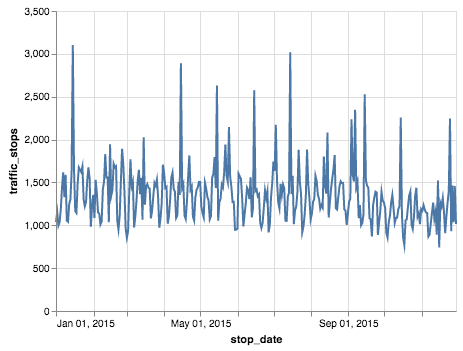

In [9]:
alt.Chart(stops_by_day).mark_line().encode(x = 'stop_date:T', y = 'traffic_stops')

There's something fishy here. You can see there are spikes throughout the year where there are more stops than normal. Let's see if we can find out more information about those spikes. We can do this by filtering the `stops_by_day` data to show only days where more than 2,000 stops occurred.

In [10]:
stops_by_day[stops_by_day['traffic_stops'] >= 2000]

,stop_date,traffic_stops
14,2015-01-15,3104
73,2015-03-15,2028
104,2015-04-15,2890
134,2015-05-15,2632
144,2015-05-25,2145
165,2015-06-15,2576
183,2015-07-03,2174
195,2015-07-15,3018
226,2015-08-15,2082
246,2015-09-04,2236


We really don't have a good answer to what is going on here. Apparently traffic stops tend to spike towards the middle of the month. Sometimes it happens at the beginning of the month and other times before hand. In some cases spikes could be related to holiday enforcement actions such as Fourth of July and Thanksgiving DUI checkpoints. Regardless additional reporting would probably be warranted. However, I don't believe this will impact our analysis greatly because time is not a factor in what we want to uncover.

### Work on your own, part I

Now that we have taken a fairly in-depth look at the `stop_date` column, let's take a closer look at counties where the stops occurred. Use the `county_name` column to generate your own table of traffic stops throughout the state.

In [11]:
# do the group by
stops_by_county = az_stops[['county_name','id']].groupby(by = 'county_name', as_index = False).count()
stops_by_county

,county_name,id
0,Apache County,14152
1,Cochise County,26613
2,Coconino County,33005
3,Gila County,15097
4,Graham County,6489
5,Greenlee County,1053
6,La Paz County,12233
7,Maricopa County,144674
8,Mohave County,20143
9,Navajo County,22506


In [12]:
# change column names
stops_by_county.rename(columns = {'county_name' : 'county', 'id' : 'traffic_stops'}, inplace = True)
stops_by_county

,county,traffic_stops
0,Apache County,14152
1,Cochise County,26613
2,Coconino County,33005
3,Gila County,15097
4,Graham County,6489
5,Greenlee County,1053
6,La Paz County,12233
7,Maricopa County,144674
8,Mohave County,20143
9,Navajo County,22506


### Coming back

So now we have an idea of how many traffic stops occurred in each county. For the purposes of our analysis this actually means very little since we will be taking a look at the entire state. However if you wanted to localize this to your area it is probably a good idea to take a look at how many stops are occurring in your coverage area.

## Visualizing the results

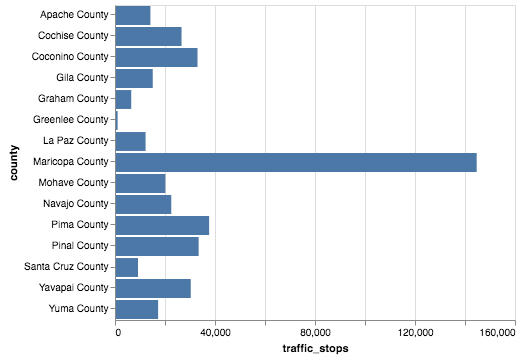

In [13]:
alt.Chart(stops_by_county).mark_bar().encode(x = 'traffic_stops', y = 'county')

## Digging into the demographics

Now we can start playing with demographic data that we have in the data set. Our initial look at the data showed us that there isn't any information on the age of the driver, but we do have pretty good data on gender and race/ethnicity. Rather than examining both gender and race separately, let's see if we can do an analysis on both columns at the same time.

To do this we will use what is called a pivot table. Those of you who have worked with Excel may be familiar with pivot tables. They are a way to restructure your data to provide a different perspective.

Before we get started though, let's do some housekeeping. The `driver_gender` column identifies gender by abbreviation. Let's change that to a full spelling.

In [14]:
az_stops['driver_gender'].replace({'F' : 'Female', 'M' : 'Male'}, inplace = True)
az_stops[['driver_gender']].head()

,driver_gender
0,Male
1,Male
2,Female
3,Female
4,Male


While we are at it let's take a peek at the `driver_race` column.

In [15]:
az_stops[['driver_race']].head()

,driver_race
0,White
1,White
2,Black
3,Hispanic
4,Asian


Much better. Now what we want to know is the number of stops by gender and race. Let's build our pivot table to show us that.

In [16]:
stops_by_sex_race = pd.pivot_table(az_stops, 
                                   columns = 'driver_gender', 
                                   index = 'driver_race', 
                                   values = 'id', 
                                   aggfunc = 'count', 
                                   margins = True,
                                   margins_name = 'Total')
stops_by_sex_race

driver_gender,Female,Male,Total
driver_race,,,
Asian,2859,8615,11474
Black,8475,20048,28523
Hispanic,32303,89769,122072
Other,12153,21459,33612
White,83136,171702,254838
Total,138926,311593,450519


Now we have our results. But again, data presented this way is a bit difficult to parse. So we should probably chart this out as well. First we have to clean the table up a bit. We need to get rid of the totals and restructure the dataframe a bit.

In [17]:
stops_by_sex_race = pd.DataFrame(stops_by_sex_race.to_records())
stops_by_sex_race = stops_by_sex_race.iloc[0:-1,0:-1] # not sure I want to do this to people
stops_by_sex_race

,driver_race,Female,Male
0,Asian,2859,8615
1,Black,8475,20048
2,Hispanic,32303,89769
3,Other,12153,21459
4,White,83136,171702
